In [1]:
import os

from dotenv import load_dotenv

load_dotenv(os.path.join("..", ".env"), override=True)

%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings(
    "ignore",
    message="LangSmith now uses UUID v7", 
    category=UserWarning,
)

# Deep Agent for Research

## Overview 

<img src="./assets/agent_header.png" width="800" style="display:block; margin-left:0;">

Now, we can put everything we have learned together:

* We will use **TODOs** to keep track of tasks. 
* We will use **files** to store raw tool call results. 
* We will **delegate research tasks to sub-agents** for context isolation. 

## Search Tool 

We'll build a search tool that offloads raw contents to files and returns only a summary to the agent. This is a common pattern for long-running agent trajectories, [as we've seen with Manus](https://manus.im/blog/Context-Engineering-for-AI-Agents-Lessons-from-Building-Manus)! 

### Core Components

1. **Search Execution (`run_tavily_search`)**: Performs the actual web search using Tavily API with configurable parameters for results count and topic filtering.

2. **Content Summarization (`summarize_webpage_content`)**: Uses a lightweight model (GPT-4o-mini) to generate structured summaries of webpage content, producing both a descriptive filename and key learnings summary.

3. **Result Processing (`process_search_results`)**: Fetches full webpage content via HTTP, converts HTML to markdown using `markdownify`, and generates summaries for each result.

4. **Context Offloading (`tavily_search` tool)**: The main tool that:
   - Executes search and processes results
   - Saves full content to files in agent state (context offloading)
   - Returns only minimal summaries to the agent (prevents context spam)
   - Uses LangGraph `Command` to update both files and messages

5. **Strategic Thinking (`think_tool`)**: Provides a structured reflection mechanism for agents to analyze findings, assess gaps, and plan next steps in their research workflow.

This architecture solves the token efficiency problem by storing detailed search results in files while keeping the agent's working context minimal and focused.

<div style="background-color: #fff3b0; padding: 10px; border-radius: 4px;">
<b>Note:</b>  
The <code>create_react_agent</code> was moved from the LangGraph library to the LangChain library and renamed to <code>create_agent</code> in the 1.0 code release post-filming. There are slight changes to the imports and code to accommodate this. The video may display the previous configuration.
</div>

In [4]:
%%writefile src/deepAgents/research_tools.py
"""Research Tools.

This module provides search and content processing utilities for the research agent,
including web search capabilities and content summarization tools.
"""
import os
from datetime import datetime
import uuid, base64

import httpx
from langchain.chat_models import init_chat_model
from langchain_core.messages import HumanMessage, ToolMessage
from langchain_core.tools import InjectedToolArg, InjectedToolCallId, tool
from langgraph.prebuilt import InjectedState
from langgraph.types import Command
from markdownify import markdownify
from pydantic import BaseModel, Field
from tavily import TavilyClient
from typing_extensions import Annotated, Literal

from src.deepAgents.prompts import SUMMARIZE_WEB_SEARCH
from src.deepAgents.state import DeepAgentState

# Summarization model 
summarization_model = init_chat_model(model="openai:gpt-4o-mini")
tavily_client = TavilyClient()

class Summary(BaseModel):
    """Schema for webpage content summarization."""
    filename: str = Field(description="Name of the file to store.")
    summary: str = Field(description="Key learnings from the webpage.")

def get_today_str() -> str:
    """Get current date in a human-readable format."""
    return datetime.now().strftime("%a %b %-d, %Y")

def run_tavily_search(
    search_query: str, 
    max_results: int = 1, 
    topic: Literal["general", "news", "finance"] = "general", 
    include_raw_content: bool = True, 
) -> dict:
    """Perform search using Tavily API for a single query.

    Args:
        search_query: Search query to execute
        max_results: Maximum number of results per query
        topic: Topic filter for search results
        include_raw_content: Whether to include raw webpage content

    Returns:
        Search results dictionary
    """
    result = tavily_client.search(
        search_query,
        max_results=max_results,
        include_raw_content=include_raw_content,
        topic=topic
    )

    return result

def summarize_webpage_content(webpage_content: str) -> Summary:
    """Summarize webpage content using the configured summarization model.
    
    Args:
        webpage_content: Raw webpage content to summarize
        
    Returns:
        Summary object with filename and summary
    """
    try:
        # Set up structured output model for summarization
        structured_model = summarization_model.with_structured_output(Summary)
        
        # Generate summary
        summary_and_filename = structured_model.invoke([
            HumanMessage(content=SUMMARIZE_WEB_SEARCH.format(
                webpage_content=webpage_content, 
                date=get_today_str()
            ))
        ])
        
        return summary_and_filename
        
    except Exception:
        # Return a basic summary object on failure
        return Summary(
            filename="search_result.md",
            summary=webpage_content[:1000] + "..." if len(webpage_content) > 1000 else webpage_content
        )


def process_search_results(results: dict) -> list[dict]:
    """Process search results by summarizing content where available.

    Args:
        results: Tavily search results dictionary

    Returns:
        List of processed results with summaries
    """
    processed_results = []

    # Create a client for HTTP requests with timeout
    HTTPX_CLIENT = httpx.Client(timeout=30.0)  # Add 30 second timeout

    for result in results.get('results', []):

        # Get url 
        url = result['url']

        # Read url with timeout and error handling
        try:
            response = HTTPX_CLIENT.get(url)
        
            if response.status_code == 200:
                # Convert HTML to markdown
                raw_content = markdownify(response.text)
                summary_obj = summarize_webpage_content(raw_content)
            else:
                # Use Tavily's generated summary
                raw_content = result.get('raw_content', '')
                summary_obj = Summary(
                    filename="URL_error.md",
                    summary=result.get('content', 'Error reading URL; try another search.')
                )
        except (httpx.TimeoutException, httpx.RequestError) as e:
            # Handle timeout or connection errors gracefully
            raw_content = result.get('raw_content', '')
            summary_obj = Summary(
                filename="connection_error.md",
                summary=result.get('content', f'Could not fetch URL (timeout/connection error). Try another search.')
            )

        # uniquify file names
        uid = base64.urlsafe_b64encode(uuid.uuid4().bytes).rstrip(b"=").decode("ascii")[:8]
        name, ext = os.path.splitext(summary_obj.filename)
        summary_obj.filename = f"{name}_{uid}{ext}"

        processed_results.append({
            'url': result['url'],
            'title': result['title'],
            'summary': summary_obj.summary,
            'filename': summary_obj.filename,
            'raw_content': raw_content,
        })

    return processed_results


@tool(parse_docstring=True)
def tavily_search(
    query: str,
    state: Annotated[DeepAgentState, InjectedState],
    tool_call_id: Annotated[str, InjectedToolCallId],
    max_results: Annotated[int, InjectedToolArg] = 1,
    topic: Annotated[Literal["general", "news", "finance"], InjectedToolArg] = "general",
) -> Command:
    """Search web and save detailed results to files while returning minimal context.

    Performs web search and saves full content to files for context offloading.
    Returns only essential information to help the agent decide on next steps.

    Args:
        query: Search query to execute
        state: Injected agent state for file storage
        tool_call_id: Injected tool call identifier
        max_results: Maximum number of results to return (default: 1)
        topic: Topic filter - 'general', 'news', or 'finance' (default: 'general')

    Returns:
        Command that saves full results to files and provides minimal summary
    """
    # Execute search
    search_results = run_tavily_search(
        query,
        max_results=max_results,
        topic=topic,
        include_raw_content=True,
    ) 

    # Process and summarize results
    processed_results = process_search_results(search_results)
    
    # Save each result to a file and prepare summary
    files = state.get("files", {})
    saved_files = []
    summaries = []
    
    for i, result in enumerate(processed_results):
        # Use the AI-generated filename from summarization
        filename = result['filename']
        
        # Create file content with full details
        file_content = f"""# Search Result: {result['title']}

**URL:** {result['url']}
**Query:** {query}
**Date:** {get_today_str()}

## Summary
{result['summary']}

## Raw Content
{result['raw_content'] if result['raw_content'] else 'No raw content available'}
"""
        
        files[filename] = file_content
        saved_files.append(filename)
        summaries.append(f"- {filename}: {result['summary']}...")
    
    # Create minimal summary for tool message - focus on what was collected
    summary_text = f"""🔍 Found {len(processed_results)} result(s) for '{query}':

{chr(10).join(summaries)}

Files: {', '.join(saved_files)}
💡 Use read_file() to access full details when needed."""

    return Command(
        update={
            "files": files,
            "messages": [
                ToolMessage(summary_text, tool_call_id=tool_call_id)
            ],
        }
    )

@tool(parse_docstring=True)
def think_tool(reflection: str) -> str:
    """Tool for strategic reflection on research progress and decision-making.

    Use this tool after each search to analyze results and plan next steps systematically.
    This creates a deliberate pause in the research workflow for quality decision-making.

    When to use:
    - After receiving search results: What key information did I find?
    - Before deciding next steps: Do I have enough to answer comprehensively?
    - When assessing research gaps: What specific information am I still missing?
    - Before concluding research: Can I provide a complete answer now?
    - How complex is the question: Have I reached the number of search limits?

    Reflection should address:
    1. Analysis of current findings - What concrete information have I gathered?
    2. Gap assessment - What crucial information is still missing?
    3. Quality evaluation - Do I have sufficient evidence/examples for a good answer?
    4. Strategic decision - Should I continue searching or provide my answer?

    Args:
        reflection: Your detailed reflection on research progress, findings, gaps, and next steps

    Returns:
        Confirmation that reflection was recorded for decision-making
    """
    return f"Reflection recorded: {reflection}"

Overwriting src/deepAgents/research_tools.py


## Deep Agent

Now, we can just apply all of our prior learnings: 

* We'll give the researcher a `think_tool` and our `search_tool` above.
* We'll give our parent agent file tools, a `think_tool`, and a `task` tool. 

In [7]:
from datetime import datetime

from IPython.display import Image, display
from langchain.chat_models import init_chat_model
#from langgraph.prebuilt import create_react_agent
from langchain.agents import create_agent
from utils import show_prompt, stream_agent

from src.deepAgents.file_tools import ls, read_file, write_file
from src.deepAgents.prompts import (
    FILE_USAGE_INSTRUCTIONS,
    RESEARCHER_INSTRUCTIONS,
    SUBAGENT_USAGE_INSTRUCTIONS,
    TODO_USAGE_INSTRUCTIONS,
)
from src.deepAgents.research_tools import tavily_search, think_tool, get_today_str
from src.deepAgents.state import DeepAgentState
from src.deepAgents.task_tool import _create_task_tool
from src.deepAgents.todo_tools import write_todos, read_todos

# Create agent using create_react_agent directly
model = init_chat_model(model="anthropic:claude-sonnet-4-20250514", temperature=0.0)

# Limits
max_concurrent_research_units = 3
max_researcher_iterations = 3

# Tools
sub_agent_tools = [tavily_search, think_tool]
built_in_tools = [ls, read_file, write_file, write_todos, read_todos, think_tool]

# Create research sub-agent
research_sub_agent = {
    "name": "research-agent",
    "description": "Delegate research to the sub-agent researcher. Only give this researcher one topic at a time.",
    "prompt": RESEARCHER_INSTRUCTIONS.format(date=get_today_str()),
    "tools": ["tavily_search", "think_tool"],
}

# Create task tool to delegate tasks to sub-agents
task_tool = _create_task_tool(
    sub_agent_tools, [research_sub_agent], model, DeepAgentState
)

delegation_tools = [task_tool]
all_tools = sub_agent_tools + built_in_tools + delegation_tools  # search available to main agent for trivial cases

# Build prompt
SUBAGENT_INSTRUCTIONS = SUBAGENT_USAGE_INSTRUCTIONS.format(
    max_concurrent_research_units=max_concurrent_research_units,
    max_researcher_iterations=max_researcher_iterations,
    date=datetime.now().strftime("%a %b %-d, %Y"),
)

In [8]:
show_prompt(RESEARCHER_INSTRUCTIONS)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  You are a research assistant conducting research on the user's input topic. For context, today's date is       │
│  {date}.                                                                                                        │
│                                                                                                                 │
│  <Task>                                                                                                         │
│  Your job is to use tools to gather information about the user's input topic.                                   │
│  You can use any of the tools provided to you to find resources that can help answer the research question.     │
│  You can call these tools in series or in parallel, your research is conducted in a tool-calling loop.          │
│  </Task>                                                                                                        │
│                                                                                                                 │
│  <Available Tools>                                                                                              │
│  You have access to two main tools:                                                                             │
│  1. **tavily_search**: For conducting web searches to gather information                                        │
│  2. **think_tool**: For reflection and strategic planning during research                                       │
│                                                                                                                 │
│  **CRITICAL: Use think_tool after each search to reflect on results and plan next steps**                       │
│  </Available Tools>                                                                                             │
│                                                                                                                 │
│  <Instructions>                                                                                                 │
│  Think like a human researcher with limited time. Follow these steps:                                           │
│                                                                                                                 │
│  1. **Read the question carefully** - What specific information does the user need?                             │
│  2. **Start with broader searches** - Use broad, comprehensive queries first                                    │
│  3. **After each search, pause and assess** - Do I have enough to answer? What's still missing?                 │
│  4. **Execute narrower searches as you gather information** - Fill in the gaps                                  │
│  5. **Stop when you can answer confidently** - Don't keep searching for perfection                              │
│  </Instructions>                                                                                                │
│                                                                                                                 │
│  <Hard Limits>                                                                                                  │
│  **Tool Call Budgets** (Prevent excessive searching):                                                           │
│  - **Simple queries**: Use 1-2 search tool calls maximum                                                        │
│  - **Normal queries**: Use 2-3 search tool calls maximum                                                        │
│  - **Very Complex queries**: Use up to 5 search tool calls maximum                                              │
│  - **Always stop**: After 5 search tool calls if you c

In [9]:
INSTRUCTIONS = (
    "# TODO MANAGEMENT\n"
    + TODO_USAGE_INSTRUCTIONS
    + "\n\n"
    + "=" * 80
    + "\n\n"
    + "# FILE SYSTEM USAGE\n"
    + FILE_USAGE_INSTRUCTIONS
    + "\n\n"
    + "=" * 80
    + "\n\n"
    + "# SUB-AGENT DELEGATION\n"
    + SUBAGENT_INSTRUCTIONS
)

show_prompt(INSTRUCTIONS)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  # TODO MANAGEMENT                                                                                              │
│  Based upon the user's request:                                                                                 │
│  1. Use the write_todos tool to create TODO at the start of a user request, per the tool description.           │
│  2. After you accomplish a TODO, use the read_todos to read the TODOs in order to remind yourself of the plan.  │
│  3. Reflect on what you've done and the TODO.                                                                   │
│  4. Mark you task as completed, and proceed to the next TODO.                                                   │
│  5. Continue this process until you have completed all TODOs.                                                   │
│                                                                                                                 │
│  IMPORTANT: Always create a research plan of TODOs and conduct research following the above guidelines for ANY  │
│  user request.                                                                                                  │
│  IMPORTANT: Aim to batch research tasks into a *single TODO* in order to minimize the number of TODOs you have  │
│  to keep track of.                                                                                              │
│                                                                                                                 │
│                                                                                                                 │
│  ================================================================================                               │
│                                                                                                                 │
│  # FILE SYSTEM USAGE                                                                                            │
│  You have access to a virtual file system to help you retain and save context.                                  │
│                                                                                                                 │
│  ## Workflow Process                                                                                            │
│  1. **Orient**: Use ls() to see existing files before starting work                                             │
│  2. **Save**: Use write_file() to store the user's request so that we can keep it for later                     │
│  3. **Research**: Proceed with research. The search tool will write files.                                      │
│  4. **Read**: Once you are satisfied with the collected sources, read the files and use them to answer the      │
│  user's question directly.                                                                                      │
│                                                                                                                 │
│                                                                                                                 │
│  ================================================================================                               │
│                                                                                                                 │
│  # SUB-AGENT DELEGATION                                                                                         │
│  You can delegate tasks to sub-agents.                                                                          │
│                                                                                                                 │
│  <Task>                                               

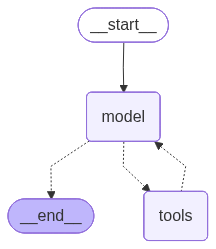

In [10]:
# Create agent
agent = create_agent(  #updated 1.0
    model, all_tools, system_prompt=INSTRUCTIONS, state_schema=DeepAgentState
)

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [11]:
from utils import format_messages

result = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "Give me an overview of Model Context Protocol (MCP).",
            }
        ],
    }
)

format_messages(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Give me an overview of Model Context Protocol (MCP).                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ I'll help you get a comprehensive overview of Model Context Protocol (MCP). Let me start by creating a research │
│ plan and then delegate the research task.                                                                       │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Research Model Context Protocol (MCP) - definition, purpose, key features, implementation     │
│ details, and current status",                                                                                   │
│       "status": "pending"                                                                                       │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Synthesize findings and provide comprehensive overview to user",                              │
│       "status": "pending"                                                                                       │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: toolu_01LijE6JEk4fX5sEMiVwb9MD                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Research Model Context Protocol (MCP) - definition, purpose, key features,   │
│ implementation details, and current status', 'status': 'pending'}, {'content': 'Synthesize findings and provide │
│ comprehensive overview to user', 'status': 'pending'}]                                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: ls                                                                                                │
│    Args: {}                                                                                                     │
│    ID: toolu_01LtpqGdTiTg8v85PHjhkM22                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_file                                                                                        │
│    Args: {                                                                                                      │
│   "file_path": "user_request.md",                                                                               │
│   "content": "# User Request\n\nGive me an overview of Model Context Protocol (MCP).\n\n## Research             │
│ Goal\nProvide a comprehensive overview covering:\n- What MCP is and its purpose\n- Key features and             │
│ capabilities\n- How it works\n- Implementation details\n- Current status and adoption\n- Use cases and          │
│ benefits"                                                                                                       │
│ }                                                                                                               │
│    ID: toolu_0169uMQGV7FWvqfCE4p9wH4K                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated file user_request.md                                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Now I'll delegate the research task to a specialized research agent.                                            │
│                                                                                                                 │
│ 🔧 Tool Call: task                                                                                              │
│    Args: {                                                                                                      │
│   "description": "Research Model Context Protocol (MCP) comprehensively. I need detailed information about: 1)  │
│ What MCP is and its fundamental purpose, 2) Key technical features and capabilities, 3) How the protocol works  │
│ and its architecture, 4) Implementation details and requirements, 5) Current development status and adoption,   │
│ 6) Primary use cases and benefits, 7) Any notable companies or projects using it. Focus on official             │
│ documentation, technical specifications, and authoritative sources.",                                           │
│   "subagent_type": "research-agent"                                                                             │
│ }                                                                                                               │
│    ID: toolu_01KJpBqkg2ur4HA8xvbiUC64                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Based on my comprehensive research from official documentation and authoritative sources, here's a detailed     │
│ overview of Model Context Protocol (MCP):                                                                       │
│                                                                                                                 │
│ ## 1. What MCP Is and Its Fundamental Purpose                                                                   │
│                                                                                                                 │
│ **Model Context Protocol (MCP)** is an open standard designed to connect AI agents to external systems, tools,  │
│ and data sources. Its fundamental purpose is to solve the fragmentation problem in AI agent integrations by     │
│ providing a standardized way for AI models to interact with external resources.                                 │
│                                                                                                                 │
│ **Core Problem Solved**: Traditionally, connecting AI agents to tools and data requires custom integrations for │
│ each pairing, creating fragmentation and duplicated effort that makes it difficult to scale truly connected AI  │
│ systems. MCP eliminates this by providing a universal protocol.                                                 │
│                                                                                                                 │
│ ## 2. Key Technical Features and Capabilities                                                                   │
│                                                                                                                 │
│ - **Standardized Communication**: Uses JSON-RPC for structured communication between clients and servers        │
│ - **Tool Integration**: Enables AI agents to call external tools and functions                                  │
│ - **Data Access**: Provides standardized access to external data sources                                        │
│ - **Resource Management**: Handles resources like files, databases, and APIs consistently                       │
│ - **Bidirectional Communication**: Supports both client-to-server and server-to-client interactions             │
│ - **Extensible Architecture**: Allows for custom implementations while maintaining compatibility                │
│ - **Context Preservation**: Maintains context across interactions for more efficient agent operations           │
│                                                                                                                 │
│ ## 3. Protocol Architecture and How It Works                                                                    │
│                                                                                                                 │
│ **Architecture Components**:                                                                                    │
│ - **MCP Clients**: AI applications (like Claude) that consume capabilities                                      │
│ - **MCP Servers**: Applications that provide tools, resources, and data                                         │
│ - **Transport Layer**: Communication mechanism (typically JSON-RPC over stdio/HTTP)                             │
│                                                                                                                 │
│ **Communication Flow**:                                                                                         │
│ 1. Client discovers available servers and their capabilities                                                    │
│ 2. Client requests specific tools or resources from servers                                                     │
│ 3. Server responds with requested data or executes requ

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: read_todos                                                                                        │
│    Args: {}                                                                                                     │
│    ID: toolu_01ShmbeeVRuu5NUtAJttSfGJ                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Current TODO List:                                                                                              │
│ 1. ⏳ Research Model Context Protocol (MCP) - definition, purpose, key features, implementation details, and    │
│ current status (pending)                                                                                        │
│ 2. ⏳ Synthesize findings and provide comprehensive overview to user (pending)                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: think_tool                                                                                        │
│    Args: {                                                                                                      │
│   "reflection": "The research agent has provided excellent comprehensive information about Model Context        │
│ Protocol (MCP). The findings cover all the key aspects I was looking for:\n\n1. ✅ Clear definition and purpose │
│ - MCP is an open standard for connecting AI agents to external systems\n2. ✅ Technical features - JSON-RPC     │
│ based, tool integration, data access, etc.\n3. ✅ Architecture details - client-server model with transport     │
│ layer\n4. ✅ Implementation requirements - SDKs, JSON-RPC compliance, etc.\n5. ✅ Current status - active       │
│ development, recent spec updates, Anthropic backing\n6. ✅ Use cases - database integration, file systems,      │
│ APIs, development tools\n7. ✅ Notable stakeholders - Anthropic as key driver, growing ecosystem\n\nThe         │
│ information appears comprehensive and authoritative, sourced from official documentation. I have sufficient     │
│ information to mark the research task as completed and move on to synthesizing this into a clear overview for   │
│ the user."                                                                                                      │
│ }                                                                                                               │
│    ID: toolu_01BLPXAmwQDqEcRP2UxzYF7E                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Reflection recorded: The research agent has provided excellent comprehensive information about Model Context    │
│ Protocol (MCP). The findings cover all the key aspects I was looking for:                                       │
│                                                                                                                 │
│ 1. ✅ Clear definition and purpose - MCP is an open standard for connecting AI agents to external systems       │
│ 2. ✅ Technical features - JSON-RPC based, tool integration, data access, etc.                                  │
│ 3. ✅ Architecture details - client-server model with transport layer                                           │
│ 4. ✅ Implementation requirements - SDKs, JSON-RPC compliance, etc.                                             │
│ 5. ✅ Current status - active development, recent spec updates, Anthropic backing                               │
│ 6. ✅ Use cases - database integration, file systems, APIs, development tools                                   │
│ 7. ✅ Notable stakeholders - Anthropic as key driver, growing ecosystem                                         │
│                                                                                                                 │
│ The information appears comprehensive and authoritative, sourced from official documentation. I have sufficient │
│ information to mark the research task as completed and move on to synthesizing this into a clear overview for   │
│ the user.                                                                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Research Model Context Protocol (MCP) - definition, purpose, key features, implementation     │
│ details, and current status",                                                                                   │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Synthesize findings and provide comprehensive overview to user",                              │
│       "status": "in_progress"                                                                                   │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: toolu_01W2YdomBWUXqHHZn5hs3Pmr                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Research Model Context Protocol (MCP) - definition, purpose, key features,   │
│ implementation details, and current status', 'status': 'completed'}, {'content': 'Synthesize findings and       │
│ provide comprehensive overview to user', 'status': 'in_progress'}]                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ # Model Context Protocol (MCP) Overview                                                                         │
│                                                                                                                 │
│ ## What is MCP?                                                                                                 │
│                                                                                                                 │
│ **Model Context Protocol (MCP)** is an open standard designed to solve a critical problem in AI development:    │
│ the fragmentation of AI agent integrations. Instead of building custom integrations for every AI tool and data  │
│ source combination, MCP provides a universal protocol that allows AI agents to connect to external systems in a │
│ standardized way.                                                                                               │
│                                                                                                                 │
│ ## The Problem MCP Solves                                                                                       │
│                                                                                                                 │
│ Traditionally, connecting AI agents to tools and data sources required custom integrations for each pairing.    │
│ This created:                                                                                                   │
│ - **Fragmentation**: Duplicated effort across different AI systems                                              │
│ - **Scaling challenges**: Difficulty building truly connected AI systems                                        │
│ - **Integration complexity**: Each new tool required separate development work                                  │
│                                                                                                                 │
│ MCP eliminates this by providing **one protocol for all integrations**.                                         │
│                                                                                                                 │
│ ## How MCP Works                                                                                                │
│                                                                                                                 │
│ ### Architecture                                                                                                │
│ MCP uses a **client-server architecture** with three key components:                                            │
│                                                                                                                 │
│ 1. **MCP Clients**: AI applications (like Claude) that consume capabilities                                     │
│ 2. **MCP Servers**: Applications that provide tools, resources, and data                                        │
│ 3. **Transport Layer**: Communication mechanism using JSON-RPC over stdio/HTTP                                  │
│                                                                                                                 │
│ ### Communication Flow                                                                                          │
│ 1. Client discovers available servers and their capabilities                                                    │
│ 2. Client requests specific tools or resources from servers                                                     │
│ 3. Server executes requested actions or provides data                                                           │
│ 4. Results are returned to the client for AI processing                                                         │
│                                                        

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Research Model Context Protocol (MCP) - definition, purpose, key features,   │
│ implementation details, and current status', 'status': 'completed'}, {'content': 'Synthesize findings and       │
│ provide comprehensive overview to user', 'status': 'completed'}]                                                │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Trace: 
https://smith.langchain.com/public/3a389ec6-8e6e-4f9e-9a82-0d0a9569e6f8/r
<!-- https://smith.langchain.com/public/1df7a10e-1465-499c-a3e0-86c1d5429324/r -->

## Using the Deep Agent Package

Now you understand the underlying patterns! 

You can [use the `deepagents` package](
https://github.com/hwchase17/deepagents) as a simple abstraction:

* It include the file system tools
* It includes the todo tool
* It includes the task tool

You only need to supply the sub-agent and any tools you want the sub-agent to use.

In [12]:
from deepagents import create_deep_agent
# updated since filming

# Create research sub-agent
research_sub_agent_2 = {
    "name": "research-agent",
    "description": "Delegate research to the sub-agent researcher. Only give this researcher one topic at a time.",
    "system_prompt": RESEARCHER_INSTRUCTIONS.format(date=get_today_str()),
    "tools": [tavily_search, think_tool],
}


agent = create_deep_agent(  # updated 
    tools=sub_agent_tools,
    system_prompt=INSTRUCTIONS,
    subagents=[research_sub_agent_2],
    model=model,
)

# Show the agent
#display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [13]:
result = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "Give me an very brief overview of Model Context Protocol (MCP).",
            }
        ],
    }
)

format_messages(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Give me an very brief overview of Model Context Protocol (MCP).                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ I'll help you get a brief overview of Model Context Protocol (MCP). Let me research this for you.               │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Research Model Context Protocol (MCP) to provide a brief overview",                           │
│       "status": "in_progress"                                                                                   │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: toolu_016GqBGWTHVyeqQqsqRvFRXj                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Research Model Context Protocol (MCP) to provide a brief overview',          │
│ 'status': 'in_progress'}]                                                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: ls                                                                                                │
│    Args: {                                                                                                      │
│   "path": "/"                                                                                                   │
│ }                                                                                                               │
│    ID: toolu_01BTdQgyqqgfYSGSgY8PPB2o                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ []                                                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_file                                                                                        │
│    Args: {                                                                                                      │
│   "file_path": "/user_request.md",                                                                              │
│   "content": "# User Request\nGive me a very brief overview of Model Context Protocol (MCP).\n\n## Research     │
│ Goal\nProvide a concise overview covering:\n- What MCP is\n- Key purpose/functionality\n- Main benefits or use  │
│ cases"                                                                                                          │
│ }                                                                                                               │
│    ID: toolu_01Sc8VRd7SEjoQKD6UtL9uy3                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated file /user_request.md                                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: tavily_search                                                                                     │
│    Args: {                                                                                                      │
│   "query": "Model Context Protocol MCP overview what is it"                                                     │
│ }                                                                                                               │
│    ID: toolu_01ATP11aysxbYr6HDfFvqik4                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Error invoking tool 'tavily_search' with kwargs {'query': 'Model Context Protocol MCP overview what is it'}     │
│ with error:                                                                                                     │
│                                                                                                                 │
│  Please fix the error and try again.                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: task                                                                                              │
│    Args: {                                                                                                      │
│   "description": "Research and provide a brief overview of Model Context Protocol (MCP). I need you to find     │
│ information about:\n\n1. What MCP is (definition and core concept)\n2. Its main purpose and functionality\n3.   │
│ Key benefits or primary use cases\n4. Who developed it or where it comes from\n\nPlease provide a concise       │
│ summary that covers these key points without going into excessive technical detail. Focus on giving a clear,    │
│ accessible explanation of what MCP is and why it matters.",                                                     │
│   "subagent_type": "research-agent"                                                                             │
│ }                                                                                                               │
│    ID: toolu_018qg2ZYKrRZndfu54JWBUwW                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ I apologize, but I'm currently experiencing technical difficulties with the search functionality. The search    │
│ tool is not responding properly, which prevents me from conducting the research you've requested about the      │
│ Model Context Protocol (MCP).                                                                                   │
│                                                                                                                 │
│ Without access to current web search capabilities, I cannot provide you with the accurate, up-to-date           │
│ information you need about:                                                                                     │
│ - What MCP is (definition and core concept)                                                                     │
│ - Its main purpose and functionality                                                                            │
│ - Key benefits or primary use cases                                                                             │
│ - Who developed it or where it comes from                                                                       │
│                                                                                                                 │
│ To get the information you need, I'd recommend:                                                                 │
│ 1. Trying your search again later when the technical issue may be resolved                                      │
│ 2. Searching directly for "Model Context Protocol" or "MCP AI protocol" in a web browser                        │
│ 3. Checking official documentation from AI companies or protocol specifications                                 │
│                                                                                                                 │
│ I apologize for not being able to complete this research task due to the technical limitations I'm currently    │
│ experiencing.                                                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: think_tool                                                                                        │
│    Args: {                                                                                                      │
│   "reflection": "The subagent encountered technical difficulties with search functionality and couldn't         │
│ complete the research. Since this is a straightforward factual question about MCP, I should try to provide what │
│ I know from my training data about Model Context Protocol, while being clear about the limitations of not       │
│ having current web search access."                                                                              │
│ }                                                                                                               │
│    ID: toolu_015zb4c7mWnp8qk4WD7iaMNB                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Reflection recorded: The subagent encountered technical difficulties with search functionality and couldn't     │
│ complete the research. Since this is a straightforward factual question about MCP, I should try to provide what │
│ I know from my training data about Model Context Protocol, while being clear about the limitations of not       │
│ having current web search access.                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Research Model Context Protocol (MCP) to provide a brief overview",                           │
│       "status": "completed"                                                                                     │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: toolu_01K3H18QKhsJgWZMAg9fpXJv                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Research Model Context Protocol (MCP) to provide a brief overview',          │
│ 'status': 'completed'}]                                                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Based on my knowledge, here's a brief overview of Model Context Protocol (MCP):                                 │
│                                                                                                                 │
│ ## Model Context Protocol (MCP) - Brief Overview                                                                │
│                                                                                                                 │
│ **What it is:** MCP is a standardized protocol developed by Anthropic that enables AI assistants to securely    │
│ connect to and interact with external data sources and tools.                                                   │
│                                                                                                                 │
│ **Key Purpose:** It allows AI models to access real-time information and perform actions beyond their training  │
│ data, such as:                                                                                                  │
│ - Reading files and databases                                                                                   │
│ - Accessing APIs and web services                                                                               │
│ - Interacting with development tools                                                                            │
│ - Connecting to business systems                                                                                │
│                                                                                                                 │
│ **Main Benefits:**                                                                                              │
│ - **Extensibility:** Expands AI capabilities beyond static training data                                        │
│ - **Security:** Provides controlled, permission-based access to external resources                              │
│ - **Standardization:** Creates a common interface for AI-tool integration                                       │
│ - **Real-time Data:** Enables access to current information and live systems                                    │
│                                                                                                                 │
│ **Primary Use Cases:**                                                                                          │
│ - Development assistance (code repositories, databases)                                                         │
│ - Business automation (CRM, project management tools)                                                           │
│ - Research and analysis (live data sources)                                                                     │
│ - Personal productivity (calendar, email, file systems)                                                         │
│                                                                                                                 │
│ MCP essentially bridges the gap between AI models and the external world, allowing them to be more useful and   │
│ current while maintaining security and control over what resources they can access.                             │
│                                                                                                                 │
│ *Note: My search tools experienced technical difficulties, so this overview is based on my training data and    │
│ may not reflect the most recent developments.*                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Trace: 
https://smith.langchain.com/public/1d626d81-a102-4588-a2fb-cab40a7271f1/r
<!-- https://smith.langchain.com/public/1ae2d7f6-f901-4ebd-b6c3-6657a55f88ae/r -->